# Assignment 2


In this assignment we will cover topics from the previous 3 lectures. We will cover the following topics:

1) Training a simple Linear Model

2) Implementing Modules with Backprop functionality

3) Implementing Convolution Module on Numpy.

4) Implement Dropout/Different Optimizer setups.

5) Implementing Pool and Training on CIFAR10?


It is crucial to get down to the nitty gritty of the code to implement all of these. No external packages (like caffe,pytorch etc), which directly give functions for these steps, are to be used. 

# Training a simple Linear Model

In this section, you will write the code to train a Linear Model. The goal is to classify and input $x_n$ of size $n$ into one of $m$ classes. For this goal, you need to create the following parts:

1) ** A weight Matrix $W_{n\times m}$ **, where the Weights are multipled to the input $X_n$ (Vector of size $n$), to find $m$ scores $S_m$ for the $m$ classes.

2) ** The Loss function **: We learnt two Kinds of Loss functions:
  *  The Hinge Loss: This loss measures, for each sample, how many times were the wrong classes scored above correct class score - $\Delta$ ? and by how much? This leads to the formulation:
  
$$
L_i = \sum_{j\neq y_i} \max(0, s_j - s_{y_i} + \Delta)
$$

where $y_i$ is the correct class, and $s_j$ is the score for the $j$-th class (the $j$-th element of $S_m$)
  
  * The softmax Loss: By interpreting the scores as unnormalized log probabilities for each class, this loss tries to measure dissatisfaction with the scores in terms of the log probability of the right class:

$$
L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) \hspace{0.5in} \text{or equivalently} \hspace{0.5in} L_i = -f_{y_i} + \log\sum_j e^{f_j}
$$

where $f_{ y_i }$ is the $i$-th element of the output of $W^T_{n \times m} . X_m$

4) ** Regularization term **: In addition to the loss, you need a Regularization term to lead to a more distributed( in case of $L_2$) or sparse (in case of $L_1$) learning of the weights. For example, and having $L_2$ regularization would imply that your loss has the following additional term:

$$
R(W) = \sum_k\sum_l W_{k,l}^2,
$$

making the total loss:
$$
L =  \underbrace{ \frac{1}{N} \sum_i L_i }_\text{data loss} + \underbrace{ \lambda R(W) }_\text{regularization loss} \\\\
$$

3) ** An Optimization Procedure **: This refers to the process which tweaks the weight Matrix $W_{n\times m}$ to reduce the loss function $L$. In our case, this refers to Mini-batch Gradient Descent algorithm. We adjust the weights $W_{n\times m}$, based on the gradient of the loss $L$ w.r.t. $W_{n\times m}$. This leads to:

$$
W_{t+1} = W_{t} + \alpha \frac{\partial L}{\partial W},
$$
where $\alpha$ is the learning rate. Additionally, as we will be doing "mini-batch" gradient Descent, instead of finding loss over the whole dataset, we find it only for a small sample of the traning data for each learning step we take. Basically,
$$
W_{t+1} = W_{t} + \alpha \frac{\partial \sum^{b}{L_{x_i}}}{\partial W},
$$
where, $b$ is the batch size.

# Question 1

Train a **Single-Layer Classifier** for the MNIST dataset. Guidelines:
* Use a loss of your choice.
* Keep a validation split of the trainingset for finding the right value of $\lambda$ for the regularization, and to check for over fitting.
* Finally,evaluate the classification performance on the testset.


Loading 60000 images
Sample Image


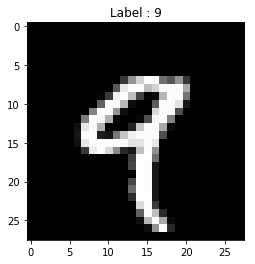

Training data and labels dimensions
(60000, 784)
(60000, 1)
Loading 10000 images
Sample Image


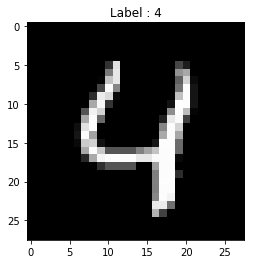

Test data and labels dimensions
(10000, 784)
(10000, 1)


In [1]:
import struct as st
import matplotlib.pyplot as plt
import numpy as np
## Load The Mnist data:
# Download data from http://yann.lecun.com/exdb/mnist/
# load the data.
def loadMNISTimages(startN,howMany,trainRtest):
    if (trainRtest == "Train"):
        fImages = open('train-images.idx3-ubyte','rb')
        fLabels = open('train-labels.idx1-ubyte','rb')
    else:
        fImages = open('t10k-images.idx3-ubyte','rb')
        fLabels = open('t10k-labels.idx1-ubyte','rb')

    # read the header information in the images file.
    s1, s2, s3, s4 = fImages.read(4), fImages.read(4), fImages.read(4), fImages.read(4)
    
    num_images = st.unpack('>I',s2)[0] # Number of images (10K Testing, 60K for Training)
    rowsIm = st.unpack('>I',s3)[0] # Number of pixels in each row of the image 28
    colsIm = st.unpack('>I',s4)[0] # Number of pixels in each column of the image 28
    
    if (howMany == "All"):
        howMany = num_images;
    print("Loading %d images"%(howMany))
    # seek to the image we want to start on
    # read the header information in the labels file and seek to position
    # in the file for the image we want to start on.
    fImages.seek(16+startN*rowsIm*colsIm)
    fLabels.seek(8+startN)

    T = []    
    for im in range(0, howMany):
        # get the input from the image file
        x = []
        for i in range(0, rowsIm*colsIm):
            val = st.unpack('>B',fImages.read(1))[0]
            x.append(val)
        # get the correct label from the labels file.
        val = st.unpack('>B',fLabels.read(1))[0]
        T.append((x,val))
            
    fImages.close()
    fLabels.close()
    
    x_train = np.zeros([howMany, rowsIm, colsIm])
    y_train = np.zeros([howMany, 1], dtype = int)
    for i in range(len(T)):
        x = T[i]
        x_train[i,:,:] = np.asarray(x[0]).reshape(28,28)
        y_train[i] = int(x[1])
    
    print('Sample Image')
    plt.figure()
    plt.imshow(x_train[4,:,:], cmap = 'gray')
    plt.title('Label : %d'%(y_train[4]))
    plt.show()
    return x_train, y_train

N = 60000
D = 28*28
x_train1, y_train = loadMNISTimages(0,N,"Train")
x_train = x_train1.reshape((N,D))

# split the data into train, and valid
num_train = int(N*0.8)
num_val = int(N*0.2)
x_tr = x_train[0:num_train]
y_tr = y_train[0:num_train]
x_val = x_train[num_train:N]
y_val = y_train[num_train:N]
print('Training data and labels dimensions')
print(x_train.shape)
print(y_train.shape)

x_test1, y_test = loadMNISTimages(0,10000,"Test")
x_test = x_test1.reshape((10000,D))
print('Test data and labels dimensions')
print(x_test.shape)
print(y_test.shape)

# Now a function, which returns a generator random mini-batch of the input data

def get_minibatch_function(training_x, training_y, batch_size, shuffle = 1):
    np.random.seed(0);
    N = training_x.shape[0]
    if shuffle ==1 :
        indices = np.random.permutation(N)
    if shuffle ==0 :
        indices = np.arange(N)
    #batch_size = 50
    num_batches = int(N/batch_size)
    def get_minibatch(training_x=training_x, training_y=training_y, batch_size=batch_size):
        for i in range(num_batches):
            mini_x = training_x[indices[np.arange(i*batch_size, (i+1)*batch_size,dtype=np.int32)]]
            mini_y = training_y[indices[np.arange(i*batch_size, (i+1)*batch_size,dtype=np.int32)]]
            yield mini_x,mini_y
    return get_minibatch

In [2]:
# Define the class Single Layer Classifier
class single_layer_classifier():
    
    def __init__(self, input_size, output_size):
        # Give the instance a weight matrix, initialized randomly.
        np.random.seed(100);
        self.W = 0.01 * np.random.rand(input_size, output_size)
        self.b = np.zeros((1,output_size))
        #self.W = np.random.rand(input_size, output_size)
        self.output_size = output_size
        self.input_size = input_size
        
    def forward(self, input_x):
        scores = np.dot(input_x, self.W) + self.b 
        scores = scores - np.max(scores)
        self.input_x = input_x.reshape(1,self.input_size)
        self.scores = scores
        return scores
    
    # Similarly a backward function
    # we define 2 backward functions (as Loss = L1 + L2, grad(Loss) = grad(L1) + grad(L2))
    
    def backward_from_loss(self, grad_from_loss):
        # this function returns a matrix of the same size as the weights, 
        # where each element is the partial derivative of the loss w.r.t. the respective element of weight.
        grad_matrix = np.dot(self.input_x.transpose(), grad_from_loss)
        grad_b = np.sum(grad_from_loss, axis=0, keepdims=True)
        return grad_matrix, grad_b
        
    def backward_from_l2(self):
        # this function returns a matrix of the same size as the weights, 
        # where each element is the partial derivative of the regularization_term
        # w.r.t. the respective element of weight.
        grad_matrix = 2*self.W
        return grad_matrix

In [3]:
# Now we need the loss functions,one which calculates the loss, 
# and one which give the backward gradient
# Make any one of the suggested losses

def loss_forward(input_y,scores):
    exp_scores = np.exp(scores)
    p_scores = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    #p_scores = np.exp(scores)/np.sum(np.exp(scores))
    loss = -np.log(p_scores[0, input_y] + 0.0000001)
    return loss

def loss_backward(loss, scores, input_y):
    exp_scores = np.exp(scores)
    p_scores = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    grad_from_loss = p_scores
    grad_from_loss[0,input_y] = grad_from_loss[0,input_y]-1
    return grad_from_loss        

In [9]:
# Finally the trainer:

# let it be for t iterations:
def train_t_lambda(x_tr, y_tr, num_iterations,lambda_reg):
    # make an instance of single_layer_classifier,
    c1assifier = single_layer_classifier(D, 10)
    lr1 = 1e-3
    lr = lr1
    tr_loss = []
    val_loss = []
    for t in range(num_iterations):
        loss_t = 0
        lr = lr1/((t)+1)
        # get the mini-batch yielder.
        train_batch_iter = get_minibatch_function(x_tr, y_tr, 100)
        c = train_batch_iter()
        for input_x, input_y in c:
            dw1 = np.zeros(c1assifier.W.shape)
            db = np.zeros((1,10))
            ## Write code here for each iteration of training.
            for i in range(input_x.shape[0]):
                scores = c1assifier.forward(input_x[i])
                data_loss = loss_forward(input_y[i],scores)
                #reg_loss = lambda_reg*np.sum(c1assifier.W*c1assifier.W)
                loss = data_loss
                #loss = data_loss + reg_loss
                loss_t = loss_t + loss
                grad_from_loss = loss_backward(loss, scores, input_y[i])
                dwx, dbx = c1assifier.backward_from_loss(grad_from_loss)
                dw1 = dw1 +  dwx
                db = db + dbx
            dw2 = c1assifier.backward_from_l2()
            c1assifier.W = c1assifier.W - (lr*(dw1+(lambda_reg*dw2)))
            c1assifier.b = c1assifier.b - (lr*db)
        #loss_v = validate(x_val, y_val, c1assifier)
        loss_v = validate(c1assifier)
        #print('Iteration %d, Training loss %.3f\n'%(t,loss_t/y_tr.shape[0]))
        tr_loss.append(loss_t/y_tr.shape[0])
        val_loss.append(loss_v)
    return c1assifier, tr_loss

In [5]:
# Find the performance on the validation set.
# find the top-1 accuracy on the validation set.
def validate(c1assifier, x_val = x_val, y_val = y_val):
    val_batch_iter = get_minibatch_function(x_val, y_val, 100)
    v_iter = val_batch_iter()
#    num_correct = 0
    loss = 0
    for input_x, input_y in v_iter:
        ## Write code here for each iteration of training.
        for i in range(input_x.shape[0]):
            scores = c1assifier.forward(input_x[i])
            l = loss_forward(input_y[i],scores)
            loss = loss+l
    return loss/y_val.shape[0]

def testing(x_val, y_val, c1assifier):
    val_batch_iter = get_minibatch_function(x_val, y_val, 100, 0)
    v_iter = val_batch_iter()
    classifier_rslt = np.zeros(y_val.shape)
#    num_correct = 0
    ind = 0
    for input_x, input_y in v_iter:
        for i in range(input_x.shape[0]):
            scores = c1assifier.forward(input_x[i])
            #p_scores = np.exp(scores) / np.sum(np.exp(scores))
            classifier_rslt[ind] = np.argmax(scores)
            ind = ind+1
    return classifier_rslt

def calculate_accuracy(ground_truth, classifier_rslt):
    top1_accuracy = 1.0*np.sum(ground_truth==classifier_rslt)/ground_truth.shape[0]
    class_wise_acc = np.zeros([10,1])
    for i in range(10):
        class_wise_acc[i] = 1.0*np.sum(classifier_rslt[np.where(ground_truth==i)] == i)/np.sum(ground_truth==i)
    return top1_accuracy,class_wise_acc

In [6]:
# now make a trainer function based on the above code, which trains for 't' iteration,
# and returns the performance on the validation
# Hyperparameter selection by cross validation
reg_lambda = np.array([0.1, 0.4, 0.7, 0.01, 0.001, 0.0001, 0.00001])
num_iter = 20
for i in reg_lambda:
    classifierr, tr_loss = train_t_lambda(x_tr, y_tr, 10,i)
    t1 = testing(x_val, y_val, classifierr)
    acc = calculate_accuracy(y_val, t1)
    print("Regularization Parameter : %f :: Validation Accuracy : %.2f percent"%(i, acc[0]*100))

Regularization Parameter : 0.100000 :: Validation Accuracy : 90.14 percent
Regularization Parameter : 0.400000 :: Validation Accuracy : 88.49 percent
Regularization Parameter : 0.700000 :: Validation Accuracy : 90.34 percent
Regularization Parameter : 0.010000 :: Validation Accuracy : 89.18 percent
Regularization Parameter : 0.001000 :: Validation Accuracy : 89.59 percent
Regularization Parameter : 0.000100 :: Validation Accuracy : 89.68 percent
Regularization Parameter : 0.000010 :: Validation Accuracy : 89.86 percent


In [8]:
# Find the optimal lambda and iterations t
print('Based on the performance of the classifier on the validation set, lambda is chosen as 0.1 and number of iterations as %d'%(num_iter))

Based on the performance of the classifier on the validation set, lambda is chosen as 0.1 and number of iterations as 20


Iteration 0, Training loss 2.682

Iteration 1, Training loss 1.703

Iteration 2, Training loss 1.608

Iteration 3, Training loss 1.565

Iteration 4, Training loss 1.573

Iteration 5, Training loss 1.535

Iteration 6, Training loss 1.531

Iteration 7, Training loss 1.535

Iteration 8, Training loss 1.515

Iteration 9, Training loss 1.527

Iteration 10, Training loss 1.515

Iteration 11, Training loss 1.520

Iteration 12, Training loss 1.515

Iteration 13, Training loss 1.501

Iteration 14, Training loss 1.499

Iteration 15, Training loss 1.512

Iteration 16, Training loss 1.475

Iteration 17, Training loss 1.487

Iteration 18, Training loss 1.483

Iteration 19, Training loss 1.469



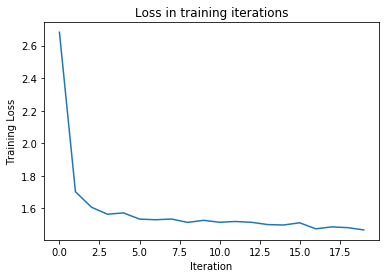

In [10]:
# Train on whole dataset with these values,(from scratch)
# report final performance on mnist test set.
# Train on whole dataset with these values,(from scratch)
classifier_final, tr_loss  = train_t_lambda(x_train, y_train, 20,0.1)
plt.plot(tr_loss)
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.title("Loss in training iterations")
plt.show()

In [11]:
# report final performance on mnist test set.
t1 = testing(x_test, y_test, classifier_final)
acc = calculate_accuracy(y_test, t1)
Top1Accuracy = acc[0]
class_wise_accuracy = acc[1]
print("Top 1 accuracy on test set : %.2f"%Top1Accuracy)
print("ClassWise Accuracies :")
for i in range(10):
    print("Class %d : %.2f"%(i,class_wise_accuracy[i]))
# Find the best performing class and the worst performing class.
print("Class %d is the best performing class with %.2f accuracy."%(np.argmax(class_wise_accuracy),np.max(class_wise_accuracy)))
print("Class %d is the worst performing class with %.2f accuracy."%(np.argmin(class_wise_accuracy),np.min(class_wise_accuracy)))

Top 1 accuracy on test set : 0.90
ClassWise Accuracies :
Class 0 : 0.95
Class 1 : 0.96
Class 2 : 0.91
Class 3 : 0.89
Class 4 : 0.92
Class 5 : 0.88
Class 6 : 0.92
Class 7 : 0.89
Class 8 : 0.81
Class 9 : 0.85
Class 1 is the best performing class with 0.96 accuracy.
Class 8 is the worst performing class with 0.81 accuracy.


# Implementing Backprop

Now that you have had some experience with single layer networks, its time to go to more complex architectures. But first we need to completely understand and implement backpropagation.

## Backpropagation:

Simple put, a way of computing gradients of expressions through recursive application of chain rule. If,
$$
L = f (g (h (\textbf{x})))
$$
then,
$$
\frac{\partial L}{\partial \textbf{x}} = \frac{\partial f}{\partial g} \times \frac{\partial g}{\partial h} \times\frac{\partial h}{\partial \textbf{x}} 
$$

** Look into the class Lecture for more detail **



# Question 2 : Scalar Backpropagation

Evaluate the gradient of the following functions w.r.t. the input.

1) $$ f(x,y,z) =  log(\sigma(\frac{cos(\pi \times \sigma(x))+sin(\pi \times \sigma(y/2))}{z^2}))$$
where $\sigma$ is the sigmoid function. Find gradient for the following values:
  * $(x,y,z)$ =  (1,2,3)
  * $(x,y,z)$ =  (3,2,1)
  * $(x,y,z)$ =  (12,23,31)
  * $(x,y,z)$ =  (32,21,13)

2) $$ f(x,y,z) = -tan(z) + exp(4x^2 + 3x + 10) - x^{y^z} $$
where $\exp$ is the exponential function. Find gradient for the following values:
  * $(x,y,z)$ =  (-0.1 ,2 ,-3)
  * $(x,y,z)$ =  (-3, 0.2,0.5)
  * $(x,y,z)$ =  (1.2, -2.3, 3.1)
  * $(x,y,z)$ =  (3.2, 2.1, -1.3)
      

In [1]:
# To solve this problem, construct the computational graph (will help understanding the problem)(not part of assignment)
# Write each component of the graph as a class, with forward and backward functions.        
# CAUTION: Carefully treat the input and output dimension variation. At worst, handle them with if statements.
# Similarly create the classes for various sub-parts/elements of the graph.
import math
class sigmoid():
    def forward(self, inp):
        result = 1 / (1+ math.exp(-inp))
        # save values useful for backpropagation
        self.result = result
        return result
    def backward(self, dresult):
        dinp = self.result*(1 - self.result)*dresult
        return dinp

class multiplyByPi():
    def forward(self, inp):
        result = inp * math.pi
        return result
    def backward(self, dresult):
        dinp = math.pi*dresult
        return dinp

class cos():
    def forward(self, inp):
        result = math.cos(inp)
        self.inp = inp
        return result
    def backward(self, dresult):
        dinp = -math.sin(self.inp)*dresult
        return dinp

class sin():
    def forward(self, inp):
        result = math.sin(inp)
        self.inp = inp
        return result
    def backward(self, dresult):
        dinp = math.cos(self.inp)*dresult
        return dinp

class divideBy2():
    def forward(self, inp):
        result = inp / 2
        return result
    def backward(self, dresult):
        dinp = 0.5*dresult
        return dinp

class add2vars():
    def forward(self, x, y):
        result = x+y
        return result
    def backward(self, dresult):
        return [dresult, dresult]

class compute_square():
    def forward(self, inp):
        result = inp*inp
        self.inp = inp
        return result
    def backward(self, dresult):
        dinp = 2*self.inp*dresult
        return dinp

class divide2vars():
    def forward(self, x, y):
        result = x/y
        self.x = x
        self.y = y
        return result
    def backward(self, dresult):
        dx = (1/self.y)*dresult
        dy = -(dresult*self.x)/(self.y*self.y)
        return [dx, dy]

class compute_log():
    def forward(self, inp):
        result = math.log(inp)
        self.inp = inp
        return result
    def backward(self, dresult):
        dinp = dresult / self.inp
        return dinp
    
class quadratic_fn():
    def forward(self, a,b,c,x):
        result = (a*x*x)+(b*x)+c
        self.a = a
        self.b = b
        self.x = x
        return result
    def backward(self, dresult):
        dx = dresult*( 2*self.a*self.x + self.b)
        return dx

class exponential_fn():
    def forward(self, inp):
        result = math.exp(inp)
        self.result = result
        return result
    def backward(self, dresult):
        dinp = dresult*self.result
        return dinp

class power_fn():
    def forward(self, x, y):
        result = pow(x, y)
        self.x = x
        self.y = y
        return result
    def backward(self, dresult):
        dx = self.y * math.pow(self.x, self.y-1)*dresult
        dy = math.pow(self.x, self.y) * math.log(self.x)*dresult
        return [dx, dy]

class negate_fn():
    def forward(self, inp):
        return -inp
    def backward(self, dresult):
        dinp = -dresult
        return dinp

class tan():
    def forward(self, inp):
        result = math.tan(inp)
        self.inp = inp
        return result
    def backward(self, dresult):
        sec_val = 1 / math.cos(self.inp)
        dinp = math.pow(sec_val, 2)*dresult
        return dinp

class add3vars():
    def forward(self, x, y, z):
        result = x+y+z
        return result
    def backward(self, dresult):
        return [dresult, dresult, dresult]

In [2]:
# Now write func_1_creator, 
# which constructs the graph(all operators), forward and backward functions.

class func1():
    def __init__(self):
        # construct the graph here, 
        self.sigx = sigmoid()
        self.mult_pi_x = multiplyByPi()
        self.cos_fn = cos()
        self.div2 = divideBy2()
        self.sigy = sigmoid()
        self.mult_pi_y = multiplyByPi()
        self.sin_fn = sin()
        self.add_fn = add2vars()
        self.square_fn = compute_square()
        self.div_fn = divide2vars()
        self.sig_last = sigmoid()
        self.log_fn = compute_log()
        # assign the instances of function modules to self.var

    def forward(self,x,y,z):
        # Using the graph element's forward functions, get the output. 
        o1 = self.sigx.forward(x)
        o2 = self.mult_pi_x.forward(o1)
        o3 = self.cos_fn.forward(o2)
        
        o4 = self.div2.forward(y)
        o5 = self.sigy.forward(o4)
        o6 = self.mult_pi_y.forward(o5)
        o7 = self.sin_fn.forward(o6)
        
        o8 = self.add_fn.forward(o3,o7)
        
        o9 = self.square_fn.forward(z)
        o10 = self.div_fn.forward(o8, o9)
        o11 = self.sig_last.forward(o10)
        output = self.log_fn.forward(o11)
        return output
    
    def backward(self):
        # Use the saved outputs of each module, and backward() function calls
        b11 = self.log_fn.backward(1)
        b10 = self.sig_last.backward(b11)
        b8, b9 = self.div_fn.backward(b10)
        
        grad_z = self.square_fn.backward(b9)
        
        b3, b7 = self.add_fn.backward(b8)
        
        b6 = self.sin_fn.backward(b7)
        b5 = self.mult_pi_y.backward(b6)
        b4 = self.sigy.backward(b5)
        grad_y = self.div2.backward(b4)
        
        b2 = self.cos_fn.backward(b3)
        b1 = self.mult_pi_x.backward(b2)
        grad_x = self.sigx.backward(b1)
        return [grad_x,grad_y,grad_z]
    
    
class func2():
    def __init__(self):
        # construct the graph here, 
        self.quad = quadratic_fn()
        self.exp_fn = exponential_fn()
        self.pow_fn1 = power_fn()
        self.pow_fn2 = power_fn()
        self.neg1 = negate_fn()
        self.tan_fn = tan()
        self.neg2 = negate_fn()
        self.add_fn = add3vars()

        # assign the instances of function modules to self.var

    def forward(self,x,y,z):
        # Using the graph element's forward functions, get the output. 
        o1 = self.quad.forward(4, 3, 10, x)
        o2 = self.exp_fn.forward(o1)
        o3 = self.pow_fn1.forward(y, z)
        
        o4 = self.pow_fn2.forward(x, o3)
        o5 = self.neg1.forward(o4)
        o6 = self.tan_fn.forward(z)
        o7 = self.neg2.forward(o6)
        
        output = self.add_fn.forward(o2,o5, o7)
        return output
    
    def backward(self):
        # Use the saved outputs of each module, and backward() function calls
        b2, b5, b7 = self.add_fn.backward(1)
        b6 = self.neg2.backward(b7)
        grad_z1 = self.tan_fn.backward(b6)
        
        b4 = self.neg2.backward(b5)
        grad_x2, b3 = self.pow_fn2.backward(b4)
        grad_y, grad_z2 = self.pow_fn1.backward(b3)
        
        b1 = self.exp_fn.backward(b2)
        grad_x1 = self.quad.backward(b1)
        grad_x = grad_x1 + grad_x2
        grad_z = grad_z1 + grad_z2
        return [grad_x,grad_y,grad_z]

In [3]:
f1 = func1()
f1_op1 = f1.forward(1,2,3)
grad_x11,grad_y11,grad_z11 = f1.backward()
print("Function 1 : \n (x,y,z) = (1,2,3) : \n grad_x = %.4f, grad_y = %.4f, grad_z = %.4f"%(grad_x11, grad_y11, grad_z11))
f1_op2 = f1.forward(3,2,1)
grad_x12,grad_y12,grad_z12 = f1.backward()
print("(x,y,z) = (3,2,1) : \n grad_x = %.4f, grad_y = %.4f, grad_z = %.4f"%(grad_x12, grad_y12, grad_z12))
f1_op3 = f1.forward(12,23,31)
grad_x13,grad_y13,grad_z13 = f1.backward()
print("(x,y,z) = (12,23,31) : \n grad_x = %.4f, grad_y = %.4f, grad_z = %.4f"%(grad_x13, grad_y13, grad_z13))
f1_op4 = f1.forward(32,21,13)
grad_x14,grad_y14,grad_z14 = f1.backward()
print("(x,y,z) = (32,21,13) : \n grad_x = %.4f, grad_y = %.4f, grad_z = %.4f"%(grad_x14, grad_y14, grad_z14))

f2 = func2()
f2_op1 = f2.forward(0.1 ,2 ,3);
grad_x21,grad_y21,grad_z21 = f2.backward()
print("\n Function 2 : \n (x,y,z) = (0.1 ,2 ,3) : \n grad_x = %.4f, grad_y = %.4f, grad_z = %.4f"%(grad_x21, grad_y21, grad_z21))
f2_op2 = f2.forward(3, 0.2,0.5);
grad_x22,grad_y22,grad_z22 = f2.backward()
print("(x,y,z) = (3, 0.2,0.5) : \n grad_x = %.4f, grad_y = %.4f, grad_z = %.4f"%(grad_x22, grad_y22, grad_z22))
f2_op3 = f2.forward(1.2, 2.3, 3.1);
grad_x23,grad_y23,grad_z23 = f2.backward()
print("(x,y,z) = (1.2, 2.3, 3.1) : \n grad_x = %.4f, grad_y = %.4f, grad_z = %.4f"%(grad_x23, grad_y23, grad_z23))
f2_op4 = f2.forward(3.2, 2.1, 1.3);
grad_x24,grad_y24,grad_z24 = f2.backward()
print("(x,y,z) = (3.2, 2.1, 1.3) : \n grad_x = %.4f, grad_y = %.4f, grad_z = %.4f"%(grad_x24, grad_y24, grad_z24))

Function 1 : 
 (x,y,z) = (1,2,3) : 
 grad_x = -0.0255, grad_y = -0.0113, grad_z = -0.0031
(x,y,z) = (3,2,1) : 
 grad_x = -0.0118, grad_y = -0.1148, grad_z = 0.2699
(x,y,z) = (12,23,31) : 
 grad_x = -0.0000, grad_y = -0.0000, grad_z = 0.0000
(x,y,z) = (32,21,13) : 
 grad_x = -0.0000, grad_y = -0.0000, grad_z = 0.0005

 Function 2 : 
 (x,y,z) = (0.1 ,2 ,3) : 
 grad_x = 117594.9142, grad_y = 0.0000, grad_z = -1.0203
(x,y,z) = (3, 0.2,0.5) : 
 grad_x = 20775920215883446914908160.0000, grad_y = -2.0076, grad_z = -0.0060
(x,y,z) = (1.2, 2.3, 3.1) : 
 grad_x = 3223381419.7416, grad_y = -36.2164, grad_z = -23.3822
(x,y,z) = (3.2, 2.1, 1.3) : 
 grad_x = 5717943466907863855300345856.0000, grad_y = -39.9501, grad_z = -61.8560


## Question 3 : Modular Vector Backpropagation

* Construct a Linear Layer module, implementing the forward and backward functions for arbitrary sizes.
* Construct a ReLU module, implementing the forward and backward functions for arbitrary sizes.
* Create a 2 layer MLP using the constructed modules.

* Modifying the functions built in Question 1 , train this two layer MLP for the same data set (MNIST).

In [12]:
# Some Functions in question1 are used. Hence Q1 solution before Q3

# Class for Linear Layer (Refer code of pytorch/tensorflow package if required.) 
# Class for Linear Layer
class linear_layer():
    
    def __init__(self, input_size, output_size):
        # Give the instance a weight matrix, initialized randomly.
        np.random.seed(0);
        self.W = 0.01*np.random.rand(input_size, output_size)
        self.output_size = output_size
        self.input_size = input_size
        
    # Define the forward function
    def forward(self, input_x):
        # get the scores
        scores = np.dot(input_x, self.W)
        #scores = scores - np.max(scores)
        self.input_x = input_x.reshape(1,self.input_size)
        self.scores = scores
        return scores
    
    # Similarly a backward function
    # we define 2 backward functions (as Loss = L1 + L2, grad(Loss) = grad(L1) + grad(L2))
    
    def backward_from_loss(self, grad_from_loss):
        # this function returns a matrix of the same size as the weights, 
        # where each element is the partial derivative of the loss w.r.t. the respective element of weight.
        grad_W = np.dot(self.input_x.transpose(), grad_from_loss.transpose())
        grad_inp = np.matmul(self.W, grad_from_loss)
        return grad_W, grad_inp
        
    def backward_from_l2(self):
        # this function returns a matrix of the same size as the weights, 
        # where each element is the partial derivative of the regularization_term
        # w.r.t. the respective element of weight.
        grad_matrix = 2*self.W
        return grad_matrix

In [13]:
# Class for ReLU
class re_lu_nonlinearity():

    # Define the forward function
    def forward(self, input_x):
        output_x = np.maximum(0, input_x)
        self.input_x = input_x
        return output_x
    
    def backward(self, grad_from_loss):
        grad_from_loss[np.where(self.input_x < 0)] = 0
        return grad_from_loss

In [14]:
# Your 2 layer MLP 
class two_layer_MLP():
    def __init__(self, input_size, hidden_layer_size, output_size):
        self.l1 = linear_layer(input_size, hidden_layer_size)
        self.re_lu = re_lu_nonlinearity()
        self.l2 = linear_layer(hidden_layer_size, output_size)
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.output_size = output_size

    # Define the forward function
    def forward(self, input_x):
        o1 = self.l1.forward(input_x)
        h = self.re_lu.forward(o1)
        o2 = self.l2.forward(h)
        output_x = o2
        self.input_x = input_x
        return output_x
    
    def backward(self, grad_from_loss):
        dl_do2 = grad_from_loss
        dl_dw2, dh = self.l2.backward_from_loss(dl_do2)
        do2_dh = dh
        dh_do1 = self.re_lu.backward(do2_dh)
        dl_dw1, x = self.l1.backward_from_loss(dh_do1)
        return dl_dw1, dl_dw2
    
def loss_forward1(input_y,scores):
    scores = (scores - np.max(scores)).reshape(10,1)
    #exp_scores = np.exp(scores)
    #p_scores = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    p_scores = np.exp(scores)/np.sum(np.exp(scores))
    loss = -np.log(p_scores[input_y] + 0.0000001)
    return loss

def loss_backward1(loss, scores, input_y):
    scores = (scores - np.max(scores)).reshape(10,1)
    p_scores = np.exp(scores)/np.sum(np.exp(scores))
    grad_from_loss = p_scores
    grad_from_loss[input_y] = grad_from_loss[input_y]-1
    return grad_from_loss

In [32]:
# Train the MLP
def train_t_lambda(x_tr, y_tr, num_iterations, H_dim):
    # make an instance of single_layer_classifier,
    c1assifier = two_layer_MLP(D, H_dim, 10)
    lr1 = 1e-5
    lambda_reg = 0.0001
    lr = lr1
    tr_loss = []
    val_loss = []
    for t in range(num_iterations):
        loss_t = 0
        lr = lr1/((t)+1)
        # get the mini-batch yielder.
        train_batch_iter = get_minibatch_function(x_tr, y_tr, 100)
        c = train_batch_iter()
        for input_x, input_y in c:
            dw1 = np.zeros(c1assifier.l1.W.shape)
            dw2 = np.zeros(c1assifier.l2.W.shape)
            ## Write code here for each iteration of training.
            for i in range(input_x.shape[0]):
                scores = c1assifier.forward(input_x[i])
                data_loss = loss_forward1(input_y[i],scores)
                #reg_loss = lambda_reg*np.sum(c1assifier.W*c1assifier.W)
                loss = data_loss
                #loss = data_loss + reg_loss
                loss_t = loss_t + loss
                grad_from_loss = loss_backward1(loss, scores, input_y[i])
                dwl1, dwl2 = c1assifier.backward(grad_from_loss)
                dw1 = dw1 +  dwl1
                dw2 = dw2 +  dwl2
            
            dw1_reg = c1assifier.l1.backward_from_l2()
            dw2_reg = c1assifier.l2.backward_from_l2()
            c1assifier.l1.W = c1assifier.l1.W - (lr*(dw1+(lambda_reg*dw1_reg)))
            c1assifier.l2.W = c1assifier.l2.W - (lr*(dw2+(lambda_reg*dw2_reg)))
        tr_loss.append(loss_t)
        #loss_v = validate(x_val, y_val, c1assifier)
        loss_v = validate(c1assifier)
        #if t%10 == 0:
        print('Iteration %d, Training loss %.3f\n'%(t,loss_t/y_tr.shape[0]))
        tr_loss.append(loss_t/y_tr.shape[0])
        val_loss.append(loss_v)
    return c1assifier, tr_loss

def validate(c1assifier, x_val = x_val, y_val = y_val):
    val_batch_iter = get_minibatch_function(x_val, y_val, 100)
    v_iter = val_batch_iter()
    loss = 0
    for input_x, input_y in v_iter:
        ## Write code here for each iteration of training.
        for i in range(input_x.shape[0]):
            scores = c1assifier.forward(input_x[i])
            l = loss_forward1(input_y[i],scores)
            loss = loss+l
    return loss/y_val.shape[0]

In [16]:
# Validation Performance
# Number of hidden neurons is chosen based on validation performance and complexity
classifier_final, tr_loss  = train_t_lambda(x_tr, y_tr, 15,100)

Iteration 0, Training loss 1.929, Validation Loss 1.421

Iteration 1, Training loss 1.220, Validation Loss 0.975

Iteration 2, Training loss 0.907, Validation Loss 0.805

Iteration 3, Training loss 0.810, Validation Loss 0.755

Iteration 4, Training loss 0.771, Validation Loss 0.730

Iteration 5, Training loss 0.748, Validation Loss 0.714

Iteration 6, Training loss 0.732, Validation Loss 0.704

Iteration 7, Training loss 0.720, Validation Loss 0.696

Iteration 8, Training loss 0.711, Validation Loss 0.689

Iteration 9, Training loss 0.703, Validation Loss 0.682

Iteration 10, Training loss 0.694, Validation Loss 0.674

Iteration 11, Training loss 0.684, Validation Loss 0.666

Iteration 12, Training loss 0.674, Validation Loss 0.657

Iteration 13, Training loss 0.665, Validation Loss 0.649

Iteration 14, Training loss 0.656, Validation Loss 0.642



In [34]:
#### Training
classifier_final, tr_loss  = train_t_lambda(x_train, y_train, 15,100)

Iteration 0, Training loss 1.818

Iteration 1, Training loss 1.174

Iteration 2, Training loss 0.781

Iteration 3, Training loss 0.533

Iteration 4, Training loss 0.467

Iteration 5, Training loss 0.429

Iteration 6, Training loss 0.408

Iteration 7, Training loss 0.394

Iteration 8, Training loss 0.383

Iteration 9, Training loss 0.374

Iteration 10, Training loss 0.367

Iteration 11, Training loss 0.359

Iteration 12, Training loss 0.353

Iteration 13, Training loss 0.347

Iteration 14, Training loss 0.342



In [37]:
# Best Class and worst class performance.
# report final performance on mnist test set.
t1 = testing(x_test, y_test, classifier_final)
acc = calculate_accuracy(y_test, t1)
Top1Accuracy = acc[0]
class_wise_accuracy = acc[1]
print("Top 1 accuracy on test set : %.2f"%Top1Accuracy)
print("ClassWise Accuracies :")
for i in range(10):
    print("Class %d : %.2f"%(i,class_wise_accuracy[i]))
# Find the best performing class and the worst performing class.
print("Class %d is the best performing class with %.2f accuracy."%(np.argmax(class_wise_accuracy),np.max(class_wise_accuracy)))
print("Class %d is the worst performing class with %.2f accuracy."%(np.argmin(class_wise_accuracy),np.min(class_wise_accuracy)))

Top 1 accuracy on test set : 0.90
ClassWise Accuracies :
Class 0 : 0.97
Class 1 : 0.98
Class 2 : 0.90
Class 3 : 0.89
Class 4 : 0.91
Class 5 : 0.79
Class 6 : 0.92
Class 7 : 0.92
Class 8 : 0.84
Class 9 : 0.88
Class 1 is the best performing class with 0.98 accuracy.
Class 5 is the worst performing class with 0.79 accuracy.


# After the lecture on Jan 31st.

# Implementing Convolution Module on Numpy.

* This topic will require you to implement the Convolution operation using Numpy.
* You will implement <s>two</s> one methods of doing it, an intuitive <s>and an optimised</s> way.
* <s>Additional operations like dropout, batch norms.</s>
* We will use the created Module for interesting task like Blurring, Bilateral Filtering.
* Finally, we create the Backprop for this.
* <s>Train a Conv model for the same MNIST dataset. (can be a script based training, instead of having it in jupyter notebook.)</s>


## Question 4

<br>
* Implement a naive Convolution module, with basic functionalities:
  * kernel_size,padding, stride, dilation
  
* Test out the convolution layer created, by using it to do gaussian blurring on 10 random images of Cifar10 dataset

* Bonus: Bilateral filtering can also be implemented using a 2-D convolution. Try bilateral filter for the space of (X,Y,Gray). (3D space, but not 3D conv), (no speed criteria), (Hint: You have multiple filters in each conv layer.)


In [38]:
import numpy as np
import matplotlib.pyplot as plt
class convolution_layer():
    
    def __init__(self, num_filters,filter_dim, pad, stride,in_depth=3):
        ## Refer pytorch documentation/tensorflow documentation for the parameters for the layer.
        ## Random initialization of the weights
        np.random.seed(76);
        self.W = np.random.rand(in_depth, filter_dim, filter_dim,num_filters)
        self.out_channels = num_filters
        self.filter_dim = filter_dim
        self.pad = pad
        self.stride = stride
        self.in_depth = in_depth
        
    def forward(self,input):
        # Input Proprocess(According to pad etc.) Input will be of size (Batch_size, in_channels, inp_height, inp_width)
        # Reminder: Save Input for backward!
        self.input = input
        # Simple Conv operation:
        # Loop over every location in inp_height * inp_width for the whole batch
        
        # Output will be of the size (Batch_size, out_channels, out_height, out_width)
        Batch_size, in_channels, inp_height, inp_width = input.shape
        out_height = (inp_height - self.filter_dim + (2*self.pad))+1
        out_width = (inp_width - self.filter_dim + (2*self.pad))+1
        output = np.zeros([Batch_size, self.out_channels, out_height, out_width])
        for i in range(Batch_size):
            in_im = input[i]
            inp = np.zeros([in_channels, inp_height+(2*self.pad), inp_width+(2*self.pad)])
            inp[:,self.pad:inp_height+self.pad, self.pad:inp_width+self.pad] = in_im
            for ch in range(self.out_channels):
                filter_W = self.W[:,:,:,ch]
                for m in range(0, out_height):
                    for n in range(0, out_width):
                        output[i,ch,m,n] = np.sum(inp[:,m:m+self.filter_dim,n:n+self.filter_dim] * filter_W)
        return output
    
    def backward(self, grad_of_output_size):
        # Naive Implementation
        # Speed is not a concern
        # Hint: gradients from each independant operation can be summed
        grad = np.zeros(self.W.shape)
        Batch_size, in_channels, inp_height, inp_width = self.input.shape
        out_height = (inp_height - self.filter_dim + (2*self.pad))+1
        out_width = (inp_width - self.filter_dim + (2*self.pad))+1
        for b in range(Batch_size):
            in_im = self.input[b]
            inp = np.zeros([in_channels, inp_height+(2*self.pad), inp_width+(2*self.pad)])
            inp[:,self.pad:inp_height+self.pad, self.pad:inp_width+self.pad] = in_im
            for fil in range(self.out_channels):
                op_grad = grad_of_output_size[b,fil,:,:]
                for ic in range(self.in_depth):
                    for m in range(self.filter_dim):
                        for n in range(self.filter_dim):
                            grad[ic,m,n,fil] = np.sum(inp[ic, m:m+out_height, n:n+out_width]*op_grad)
        return grad
    
    def set_weights(self, new_weights):
        ## Replace the set of weights with the given 'new_weights'
        ## use this for setting weights for blurring, bilateral filtering etc.
        self.W = new_weights

In [43]:
## get cifar images
## get cifar images
def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

def load_images():
    dataset_file = 'test_batch'
    xx = unpickle(dataset_file)
    data1 = xx[b'data']
    #label = xx[b'labels']
    N = 10
    data = data1[0:N,:]
    test_data = data.reshape(N,3,32,32).transpose(0,2,3,1)
    return test_data

test_data = load_images()
test_data1 = test_data.transpose(0,3,1,2)

In [44]:
## Initialize a conv layer. Set weights for gaussian blurring
def generate_gaussian_mask(shape, sigma):
    ax = np.arange(-shape // 2 + 1., shape // 2 + 1.)
    #ax = np.arange(shape)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))

    return kernel/(2*np.pi)

## Initialize a conv layer. Set weights for gaussian blurring
filter_size = 7
num_filters = 3
stride = 1
pad = 3

c_layer = convolution_layer(num_filters,filter_size, pad, stride)
W_gauss = generate_gaussian_mask(filter_size,1)
guassian_blur_kernel = np.zeros([3, filter_size,filter_size,num_filters])
guassian_blur_kernel[0,:,:,0] = W_gauss
guassian_blur_kernel[1,:,:,1] = W_gauss
guassian_blur_kernel[2,:,:,2] = W_gauss

c_layer.set_weights(guassian_blur_kernel)

## generate output.
output = c_layer.forward(test_data1)
op = output.transpose(0,2,3,1)
op1 = np.array(op, dtype = 'uint8')

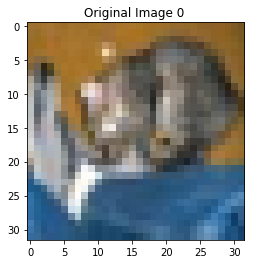

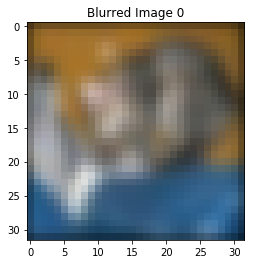

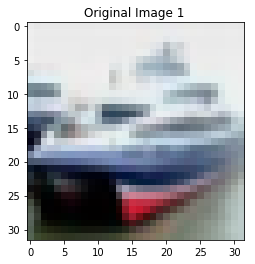

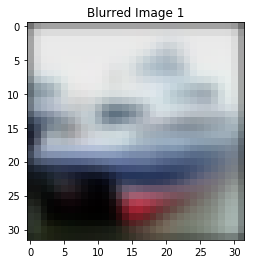

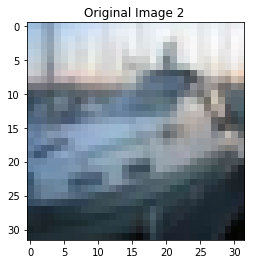

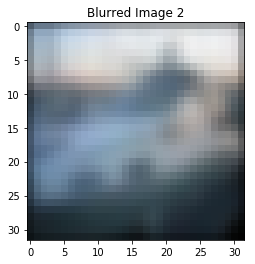

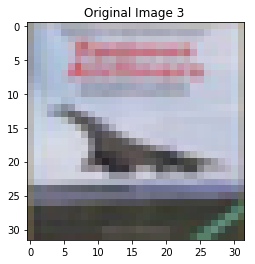

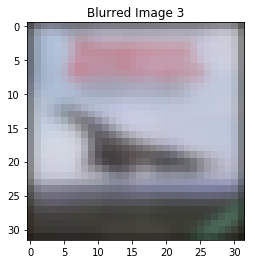

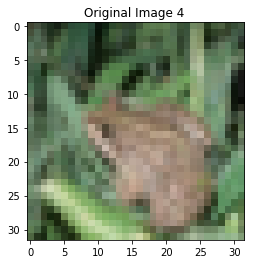

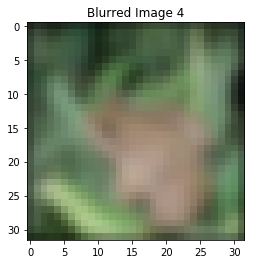

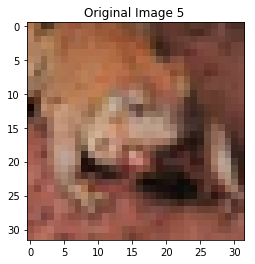

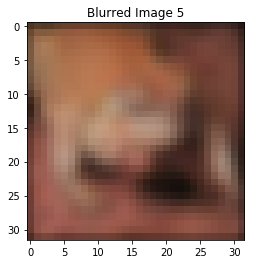

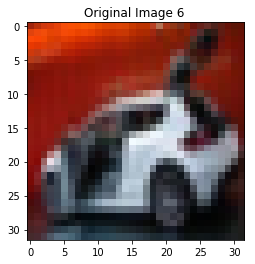

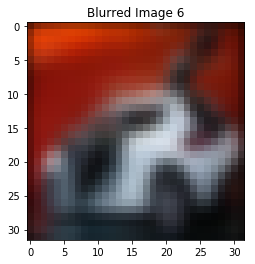

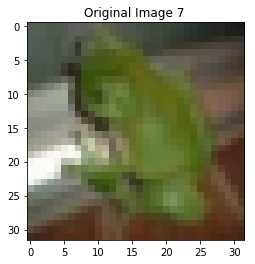

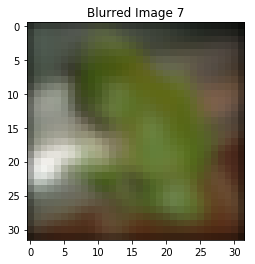

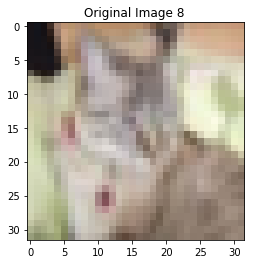

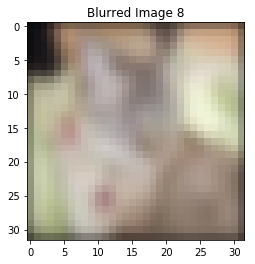

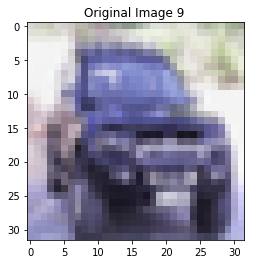

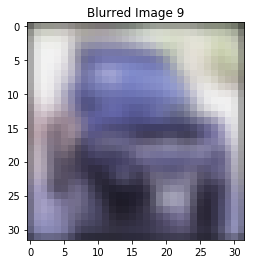

In [45]:
## use matplotlib.pyplot to show the results.
for i in range(10):
    plt.figure()
    plt.imshow(test_data[i])
    plt.title('Original Image %d '%i)
    plt.figure()
    plt.imshow(op1[i])
    plt.title('Blurred Image %d'%i)
plt.show()

## Question 5
<br>
Now we will use the created layer for training a simple Convolution Layer. 

* The goal is to make it learn a set of weights, by using the backpropagation function created. To test the backpropagation, instead of training a whole network, we will train only a single layer.
  * Take 100 cifar10 images. Generate a numpy array of size (20,3,5,5), with samples from uniform distribution (-1,1).Initialize a Convolution layer with 20 5$\times$5 kernels(input size 3) and set the generated weights as the layer weights. Save the output of these 100 images from this Convolution layer. 
  
  * Now, initialize a new convolution layer, and use $L_2$ loss between the output of the network and the output generated in the previous step to get the same set of weights as the ones generated in the previous step.


In [47]:
import numpy as np
import matplotlib.pyplot as plt

## get cifar images
def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

def load_images():
    dataset_file = 'test_batch'
    xx = unpickle(dataset_file)
    data1 = xx[b'data']
    #label = xx[b'labels']
    N = 100
    data = data1[0:N,:]
    test_data = data.reshape(N,3,32,32).transpose(0,2,3,1)
    return test_data

test_data = load_images()
test_data1 = test_data.transpose(0,3,1,2)

## First generate the random weight vector
np.random.seed(1994);
W = 2*np.random.rand(3,5,5,20) - 1

## Init a conv layer with these weights
num_filters = 20
filter_size = 5
pad = 2
stride = 0
conv_layer = convolution_layer(num_filters,filter_size, pad, stride)
conv_layer.set_weights(W)

## For all images get output. Store in numpy array.
output = conv_layer.forward(test_data1)

Iteration 0 , Batch 0 : Loss : 2933486.082462
Iteration 0 , Batch 1 : Loss : 2776752.143716
Iteration 0 , Batch 2 : Loss : 2427076.155411
Iteration 0 , Batch 3 : Loss : 2568026.500303
Iteration 0 , Batch 4 : Loss : 2524808.109759
Iteration 1 , Batch 0 : Loss : 2104245.732764
Iteration 1 , Batch 1 : Loss : 1965871.805846
Iteration 1 , Batch 2 : Loss : 1684436.611397
Iteration 1 , Batch 3 : Loss : 1741657.643183
Iteration 1 , Batch 4 : Loss : 1606102.005613
Iteration 2 , Batch 0 : Loss : 1279223.160719
Iteration 2 , Batch 1 : Loss : 1160114.653158
Iteration 2 , Batch 2 : Loss : 947459.584106
Iteration 2 , Batch 3 : Loss : 923086.260827
Iteration 2 , Batch 4 : Loss : 701706.227332
Iteration 3 , Batch 0 : Loss : 476450.696737
Iteration 3 , Batch 1 : Loss : 386451.585930
Iteration 3 , Batch 2 : Loss : 257375.013144
Iteration 3 , Batch 3 : Loss : 196636.100440
Iteration 3 , Batch 4 : Loss : 169437.324787
Iteration 4 , Batch 0 : Loss : 144341.234700
Iteration 4 , Batch 1 : Loss : 146697.05741

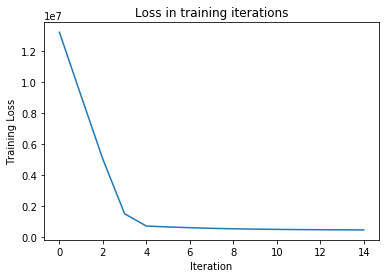

In [49]:
# for part 2 we need to write a small L2 layer
class L2_loss():
    
    def forward(self, inp_1,inp_2):
        # input is of dimestion(batch,channels,h,w)
        # calculate the l2 norm of inp_1 - inp_2 .,
        batch,channels,h,w = inp_1.shape
        diff = inp_1 - inp_2
        diff_sq = diff*diff
        se = np.sum(diff_sq)
        output = np.sqrt(se)
        self.diff = diff
        self.output = output
        return output
    
    def backward(self,output_grad):
        # from the loss, and the input, get the grad at each location of the input.
        # The grad is of the shape (batch,channels,h,w)
        grad = output_grad*(self.diff / self.output)
        return grad

# Now Init a new conv layer and a L2 loss layer
conv_layer_new = convolution_layer(num_filters,filter_size, pad, stride)
l2_layer = L2_loss()

# Train the new conv-layer using the L2 loss to get the earlier set of generated weights.
# Use batches.
lr = 1e-4
batch_size = 20
num_batches = int(100 / batch_size)
num_iter = 15
cost = []
for i in range(num_iter):
    loss_iter = 0
    for b in range(num_batches):
        data = test_data1[b*batch_size:(b+1)*batch_size]
        actual = output[b*batch_size:(b+1)*batch_size]
        op = conv_layer_new.forward(data)
        loss = l2_layer.forward(op, actual)
        loss_iter = loss_iter + loss
        dL_Do = l2_layer.backward(1)
        dW = conv_layer_new.backward(dL_Do)
        print("Iteration %d , Batch %d : Loss : %f"%(i,b,loss))
        conv_layer_new.W = conv_layer_new.W - (lr * dW)
    cost.append(loss_iter)
    
plt.plot(cost)
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.title("Loss in training iterations")
plt.show()

# Print L2 dist between output from new convolution layer and the outputs generated initially.
output1 = conv_layer_new.forward(test_data1)
rslt = l2_layer.forward(output, output1)

In [53]:
print("L2 diatance between output from new convolution layer and the actuals is %.3f"%rslt)
print("Average L2 diatance between output from new convolution layer and the actuals is %.3f"%(rslt/100.0))

L2 diatance between output from new convolution layer and the actuals is 226510.510
Average L2 diatance between output from new convolution layer and the actuals is 2265.105
